# **Importing Dependencies**

In [ ]:
# importing libraries 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from PIL import Image
import os
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from google.colab import files
from math import sqrt
from numpy import zeros
from numpy import ones
from skimage.transform import resize


Importing Dataset

In [ ]:
# unzipping file 

# mouting file 
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/PGGAN/
!mkdir dataset

/content/gdrive/MyDrive/Colab Notebooks/PGGAN
mkdir: cannot create directory ‘dataset’: File exists


In [ ]:
!unzip archive\ \(6\).zip -d dataset

# **Data Preprocessing**

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Art
!mkdir processed_dataset

/content/gdrive/MyDrive/Colab Notebooks/Art


In [ ]:
## Re-sizing images to 128 x 128 pixels

### Defining function
def center_crop(d, nb,new_width=128, new_height=128):  
  """to crop image"""
  im = Image.open(d).convert("RGB")
  width, height = im.size # Get dimensions
  left = round((width - new_width)/2)
  top = round((height - new_height)/2)
  x_right = round(width - new_width) - left
  x_bottom = round(height - new_height) - top
  right = width - x_right
  bottom = height - x_bottom

  # Crop the center of the image
  im = im.crop((left, top, right, bottom))
  # Save in the new directory
  im.save("/content/gdrive/MyDrive/Colab Notebooks/Art/processed_dataset/" + str(nb) + '.jpg', 'JPEG')

### Applying function

directory = r'/content/gdrive/MyDrive/Colab Notebooks/Art/dataset'
i = 0
for filename in os.listdir(directory):
    i += 1
    if filename.endswith(".jpg"):
        center_crop(os.path.join(directory, filename), nb = i )
    else:
        continue

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (107327830 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [ ]:
# load an image as an rgb numpy array

def load_image(filename):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = np.asarray(image)
	return pixels

# convert dataset into rgb numpy array

def dataset_creation(directory):
	art = []
	for filename in os.listdir(directory):
		# load the image
		pixels = load_image(directory + filename)
		# store
		art.append(pixels)
		print(len(art))
		# # stop once we have enough
		# if len(art) >= n_art:
		# 	break
	return np.asarray(art)
 
directory = '/content/gdrive/MyDrive/Colab Notebooks/PGGAN/dataset/cats/cats/'
data = dataset_creation(directory)

cleaned_data = np.savez_compressed('cleaned_data.npz', data)

KeyboardInterrupt: ignored

In [ ]:
# Normalize the dataset to be between -1 and 1

def load_real_samples(filename):
	# load dataset
	data = np.load(filename)
	# extract numpy array
	X = data['arr_0']
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X

training_set = load_real_samples('cleaned_data.npz')


# **Developing PGGAN**

## Defining PGGAN-specific classes

WeightedSum Layer: To phase in new higher res layers with old model


In [ ]:
class WeightedSum(keras.layers.Add):
	# init with default value
	def __init__(self, alpha=0.0, **kwargs):
		super(WeightedSum, self).__init__(**kwargs)
		self.alpha = keras.backend.variable(alpha, name='ws_alpha')
 
	# output a weighted sum of inputs
	def _merge_function(self, inputs):
		# only supports a weighted sum of two inputs
		assert (len(inputs) == 2)
		# ((1-a) * input1) + (a * input2)
		output = ((1.0 - self.alpha) * inputs[0]) + (self.alpha * inputs[1])
		return output

MinibatchStdev: Provides with statistical summary of the batch of activations (only applied to output layer of discriminator)


In [ ]:
class MinibatchStdev(keras.layers.Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(MinibatchStdev, self).__init__(**kwargs)
 
	# perform the operation
	def call(self, inputs):
		# calculate the mean value for each pixel across channels
		mean = keras.backend.mean(inputs, axis=0, keepdims=True)
		# calculate the squared differences between pixel values and mean
		squ_diffs = keras.backend.square(inputs - mean)
		# calculate the average of the squared differences (variance)
		mean_sq_diff = keras.backend.mean(squ_diffs, axis=0, keepdims=True)
		# add a small value to avoid a blow-up when we calculate stdev
		mean_sq_diff += 1e-8
		# square root of the variance (stdev)
		stdev = keras.backend.sqrt(mean_sq_diff)
		# calculate the mean standard deviation across each pixel coord
		mean_pix = keras.backend.mean(stdev, keepdims=True)
		# scale this up to be the size of one input feature map for each sample
		shape = keras.backend.shape(inputs)
		output = keras.backend.tile(mean_pix, (shape[0], shape[1], shape[2], 1))
		# concatenate with the output
		combined = keras.backend.concatenate([inputs, output], axis=-1)
		return combined
 
	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		# create a copy of the input shape as a list
		input_shape = list(input_shape)
		# add one to the channel dimension (assume channels-last)
		input_shape[-1] += 1
		# convert list to a tuple
		return tuple(input_shape)

PixelNormalization of layers after each conv layer but before each activation layer in the generator


In [ ]:
class PixelNormalization(keras.layers.Layer):
	# initialize the layer
	def __init__(self, **kwargs):
		super(PixelNormalization, self).__init__(**kwargs)
 
	# perform the operation
	def call(self, inputs):
		# calculate square pixel values
		values = inputs**2.0
		# calculate the mean pixel values
		mean_values = keras.backend.mean(values, axis=-1, keepdims=True)
		# ensure the mean is not zero
		mean_values += 1.0e-8
		# calculate the sqrt of the mean squared value (L2 norm)
		l2 = keras.backend.sqrt(mean_values)
		# normalize values by the l2 norm
		normalized = inputs / l2
		return normalized
 
	# define the output shape of the layer
	def compute_output_shape(self, input_shape):
		return input_shape

Wasserstein loss for loss function

In [ ]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return keras.backend.mean(y_true * y_pred)

## Defining Discriminator Functions

In [ ]:
def add_discriminator_block(old_model, n_input_layers=3):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# weight constraint
	const = keras.constraints.max_norm(1.0)
	# get shape of existing model
	in_shape = list(old_model.input.shape)
	# define new input shape as double the size
	input_shape = (in_shape[-2]*2, in_shape[-2]*2, in_shape[-1])
	in_image = keras.layers.Input(shape=input_shape)
	# define new input processing layer
	d = keras.layers.Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# define new block
	d = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	d = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	d = keras.layers.AveragePooling2D()(d)
	block_new = d
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model1 = keras.Model(in_image, d)
	# compile model
	model1.compile(loss=wasserstein_loss, optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# downsample the new larger image
	downsample = keras.layers.AveragePooling2D()(in_image)
	# connect old input processing to downsampled new input
	block_old = old_model.layers[1](downsample)
	block_old = old_model.layers[2](block_old)
	# fade in output of old model input layer with new input
	d = WeightedSum()([block_old, block_new])
	# skip the input, 1x1 and activation for the old model
	for i in range(n_input_layers, len(old_model.layers)):
		d = old_model.layers[i](d)
	# define straight-through model
	model2 = keras.Model(in_image, d)
	# compile model
	model2.compile(loss=wasserstein_loss, optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	return [model1, model2]
 
# define the discriminator models for each image resolution
def define_discriminator(n_blocks, input_shape=(4,4,3)):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# weight constraint
	const = keras.constraints.max_norm(1.0)
	model_list = list()
	# base model input
	in_image = keras.layers.Input(shape=input_shape)
	# conv 1x1
	d = keras.layers.Conv2D(128, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(in_image)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# conv 3x3 (output block)
	d = MinibatchStdev()(d)
	d = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# conv 4x4
	d = keras.layers.Conv2D(128, (4,4), padding='same', kernel_initializer=init, kernel_constraint=const)(d)
	d = keras.layers.LeakyReLU(alpha=0.2)(d)
	# dense output layer
	d = keras.layers.Flatten()(d)
	out_class = keras.layers.Dense(1)(d)
	# define model
	model = keras.Model(in_image, out_class)
	# compile model
	model.compile(loss=wasserstein_loss, optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0, beta_2=0.99, epsilon=10e-8))
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_discriminator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

## Defining Generator Functions

In [ ]:
def add_generator_block(old_model):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# weight constraint
	const = keras.constraints.max_norm(1.0)
	# get the end of the last block
	block_end = old_model.layers[-2].output
	# upsample, and define new block
	upsampling = keras.layers.UpSampling2D()(block_end)
	g = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(upsampling)
	g = PixelNormalization()(g)
	g = keras.layers.LeakyReLU(alpha=0.2)(g)
	g = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = keras.layers.LeakyReLU(alpha=0.2)(g)
	# add new output layer
	out_image = keras.layers.Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model1 = keras.Model(old_model.input, out_image)
	# get the output layer from old model
	out_old = old_model.layers[-1]
	# connect the upsampling to the old output layer
	out_image2 = out_old(upsampling)
	# define new output image as the weighted sum of the old and new models
	merged = WeightedSum()([out_image2, out_image])
	# define model
	model2 = keras.Model(old_model.input, merged)
	return [model1, model2]
 
# define generator models
def define_generator(latent_dim, n_blocks, in_dim=4):
	# weight initialization
	init = keras.initializers.RandomNormal(stddev=0.02)
	# weight constraint
	const = keras.constraints.max_norm(1.0)
	model_list = list()
	# base model latent input
	in_latent = keras.layers.Input(shape=(latent_dim,))
	# linear scale up to activation maps
	g  = keras.layers.Dense(128 * in_dim * in_dim, kernel_initializer=init, kernel_constraint=const)(in_latent)
	g = keras.layers.Reshape((in_dim, in_dim, 128))(g)
	# conv 4x4, input block
	g = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = keras.layers.LeakyReLU(alpha=0.2)(g)
	# conv 3x3
	g = keras.layers.Conv2D(128, (3,3), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	g = PixelNormalization()(g)
	g = keras.layers.LeakyReLU(alpha=0.2)(g)
	# conv 1x1, output block
	out_image = keras.layers.Conv2D(3, (1,1), padding='same', kernel_initializer=init, kernel_constraint=const)(g)
	# define model
	model = keras.Model(in_latent, out_image)
	# store model
	model_list.append([model, model])
	# create submodels
	for i in range(1, n_blocks):
		# get prior model without the fade-on
		old_model = model_list[i - 1][0]
		# create new model for next resolution
		models = add_generator_block(old_model)
		# store model
		model_list.append(models)
	return model_list

## Defining Composite Model

In [ ]:
# define composite models for training generators via discriminators
def define_composite(discriminators, generators):
	model_list = list()
	# create composite models
	for i in range(len(discriminators)):
		g_models, d_models = generators[i], discriminators[i]
		# straight-through model
		d_models[0].trainable = False
		model1 = keras.Sequential()
		model1.add(g_models[0])
		model1.add(d_models[0])
		model1.compile(loss=wasserstein_loss, optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# fade-in model
		d_models[1].trainable = False
		model2 = keras.Sequential()
		model2.add(g_models[1])
		model2.add(d_models[1])
		model2.compile(loss=wasserstein_loss, optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0, beta_2=0.99, epsilon=10e-8))
		# store
		model_list.append([model1, model2])
	return model_list

## Training Model

Defining necessary functions

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/PGGAN
!mkdir generated_models_4
!mkdir generated_images_4

/content/gdrive/MyDrive/Colab Notebooks/PGGAN


In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = -ones((n_samples, 1))
	return X, y

# update the alpha value on each instance of WeightedSum
def update_fadein(models, step, n_steps):
	# calculate current alpha (linear from 0 to 1)
	alpha = step / float(n_steps - 1)
	# update the alpha for each model
	for model in models:
		for layer in model.layers:
			if isinstance(layer, WeightedSum):
				keras.backend.set_value(layer.alpha, alpha)

# scale images to preferred size
def scale_dataset(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

# generate samples and save as a plot and save the model

images_dir = '/content/gdrive/MyDrive/Colab Notebooks/PGGAN/generated_images_4'
models_dir = '/content/gdrive/MyDrive/Colab Notebooks/PGGAN/generated_models_4'

import shutil

def summarize_performance(status, g_model, latent_dim, n_samples=25):
	# devise name
	gen_shape = g_model.output_shape
	name = '%03dx%03d-%s' % (gen_shape[1], gen_shape[2], status)
	# generate images
	X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
	# normalize pixel values to the range [0,1]
	X = (X - X.min()) / (X.max() - X.min())
	# plot real images
	square = int(sqrt(n_samples))
	for i in range(n_samples):
		plt.subplot(square, square, 1 + i)
		plt.axis('off')
		plt.imshow(X[i])
	# save plot to file
	filename1 = 'plot_%s.png' % (name)
	plt.savefig(f"{images_dir}/"+filename1)
	plt.close()
	# save the generator model
	filename2 = 'model_%s.h5' % (name)
	g_model.save(f"{models_dir}/"+filename2)
  # shutil.copy(,models_dir)
	print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# defining training functions 

def train_epochs(g_model, d_model, gan_model, dataset, n_epochs, n_batch, latent_dim, fadein=False):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_steps):
		# update alpha for all WeightedSum layers when fading in new blocks
		if fadein:
			update_fadein([g_model, d_model, gan_model], i, n_steps)
		# prepare real and fake samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator model
		d_loss1 = d_model.train_on_batch(X_real, y_real)
		d_loss2 = d_model.train_on_batch(X_fake, y_fake)
		# update the generator via the discriminator's error
		z_input = generate_latent_points(latent_dim, n_batch)
		y_real2 = ones((n_batch, 1))
		g_loss = gan_model.train_on_batch(z_input, y_real2)
		# summarize loss on this batch
		print('>%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, d_loss1, d_loss2, g_loss))
  

# train the generator and discriminator
def train(g_models, d_models, gan_models, dataset, latent_dim, e_norm, e_fadein, n_batch):
	# fit the baseline model
	g_normal, d_normal, gan_normal = g_models[0][0], d_models[0][0], gan_models[0][0]
	# scale dataset to appropriate size
	gen_shape = g_normal.output_shape
	scaled_data = scale_dataset(dataset, gen_shape[1:])
	print('Scaled Data', scaled_data.shape)
	# train normal or straight-through models
	train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[0], n_batch[0],latent_dim)
	summarize_performance('tuned', g_normal, latent_dim)
	# process each level of growth
	for i in range(1, len(g_models)):
		# retrieve models for this level of growth
		[g_normal, g_fadein] = g_models[i]
		[d_normal, d_fadein] = d_models[i]
		[gan_normal, gan_fadein] = gan_models[i]
		# scale dataset to appropriate size
		gen_shape = g_normal.output_shape
		scaled_data = scale_dataset(dataset, gen_shape[1:])
		print('Scaled Data', scaled_data.shape)
		# train fade-in models for next level of growth
		train_epochs(g_fadein, d_fadein, gan_fadein, scaled_data, e_fadein[i], n_batch[i],latent_dim, True)
		summarize_performance('faded', g_fadein, latent_dim)
		# train normal or straight-through models
		train_epochs(g_normal, d_normal, gan_normal, scaled_data, e_norm[i], n_batch[i], latent_dim)
		summarize_performance('tuned', g_normal, latent_dim)

Training model

In [ ]:
# number of growth phases, e.g. 5 == [4, 8, 16, 32, 64]
n_blocks = 5
# size of the latent space
latent_dim = 100
# # define models
d_models = define_discriminator(n_blocks)
# define models
g_models = define_generator(latent_dim, n_blocks)

# define composite models
gan_models = define_composite(d_models, g_models)

# Print data info

print('Loaded Dataset info:', training_set.shape)

# # train model
n_batch = [16, 16, 16, 8, 4]
# # 10 epochs == 500K images per training phase
n_epochs = [5, 8, 8, 10, 10]
train(g_models, d_models, gan_models, training_set, latent_dim, n_epochs, n_epochs, n_batch)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
>18487, d1=-0.003, d2=0.006 g=-0.006
>18488, d1=-0.007, d2=0.001 g=-0.005
>18489, d1=-0.010, d2=0.009 g=-0.004
>18490, d1=-0.005, d2=0.005 g=-0.005
>18491, d1=-0.003, d2=0.005 g=-0.007
>18492, d1=-0.000, d2=0.004 g=-0.006
>18493, d1=-0.005, d2=-0.002 g=-0.008
>18494, d1=-0.004, d2=0.002 g=-0.006
>18495, d1=0.002, d2=0.008 g=-0.006
>18496, d1=-0.004, d2=0.006 g=-0.009
>18497, d1=0.001, d2=0.006 g=-0.005
>18498, d1=-0.004, d2=0.004 g=-0.005
>18499, d1=-0.003, d2=0.001 g=-0.006
>18500, d1=0.000, d2=0.005 g=-0.006
>18501, d1=-0.003, d2=0.004 g=-0.007
>18502, d1=-0.001, d2=0.007 g=-0.005
>18503, d1=-0.006, d2=0.004 g=-0.005
>18504, d1=-0.005, d2=0.006 g=-0.005
>18505, d1=-0.004, d2=0.004 g=-0.006
>18506, d1=-0.005, d2=0.005 g=-0.005
>18507, d1=-0.007, d2=0.006 g=-0.007
>18508, d1=-0.005, d2=0.006 g=-0.005
>18509, d1=-0.003, d2=0.004 g=-0.005
>18510, d1=-0.006, d2=0.008 g=-0.004
>18511, d1=-0.005, d2=0.004 g=-0.004
>18512, d1=-0.001, d2=0.00

## **Generating images**

In [ ]:
%cd /content/gdrive/MyDrive/Colab Notebooks/PGGAN/generated_models_4/

/content/gdrive/MyDrive/Colab Notebooks/PGGAN/generated_models_4


In [ ]:
from keras.models import load_model

cust = {'PixelNormalization': PixelNormalization, 'MinibatchStdev': MinibatchStdev, 'WeightedSum': WeightedSum}
model = load_model('model_064x064-tuned.h5', cust)

In [ ]:
# size of the latent space
latent_dim = 100
# number of images to generate
n_images = 25
# generate images
latent_points = generate_latent_points(latent_dim, n_images)
# generate images
X = model.predict(latent_points)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
def plot_generated(images, n_images):
	# plot images
	square = int(sqrt(n_images))
	# normalize pixel values to the range [0,1]
	images = (images - images.min()) / (images.max() - images.min())
	for i in range(n_images):
		# define subplot
		pyplot.subplot(square, square, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(images[i])
	pyplot.show()

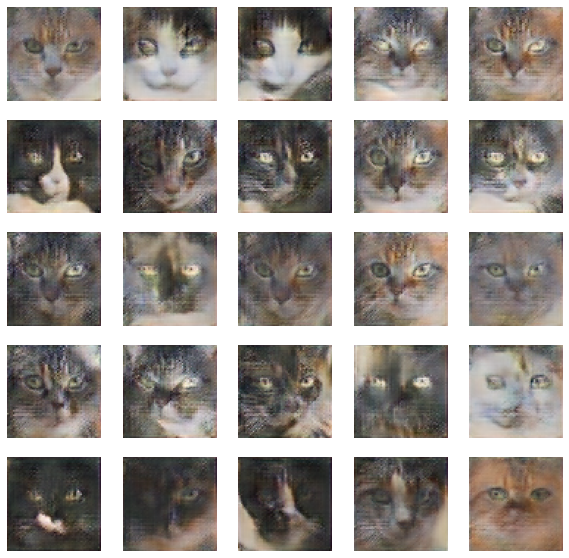

In [ ]:
plot_generated(X, n_images)